# Task 4: Model Comparison & Selection

This notebook handles:
- Loading trained models
- Performance evaluation
- Model comparison and selection

In [1]:
import sys
sys.path.append('..')

import pandas as pd
from pathlib import Path
from src.evaluation.model_evaluator import ModelEvaluator
from src.labeling.conll_labeler import CoNLLLabeler
from config.config import model_config

In [2]:
# Initialize evaluator and load test data
evaluator = ModelEvaluator()
labeler = CoNLLLabeler()

with open("../data/labeled/train_data.conll", 'r', encoding='utf-8') as f:
    conll_data = f.read()

test_data = labeler.parse_conll_data(conll_data)
test_texts = [' '.join(ex['tokens']) for ex in test_data]

print(f"Test data: {len(test_data)} examples")

Test data: 50 examples


## Load Trained Models

In [3]:
# Load all trained models
for model_name in model_config.model_names:
    model_path = f"../models/checkpoints/{model_name.replace('/', '_')}"
    if Path(model_path).exists():
        evaluator.load_model(model_path, model_name)
        print(f"Loaded: {model_name}")
    else:
        print(f"Model not found: {model_path}")

print(f"\nLoaded {len(evaluator.models)} models")

Device set to use cpu


Loaded: xlm-roberta-base


Device set to use cpu


Loaded: distilbert-base-multilingual-cased


Device set to use cpu


Loaded: bert-base-multilingual-cased

Loaded 3 models


## Evaluate Individual Models

In [4]:
# Test individual model performance
for model_name in evaluator.models.keys():
    print(f"\nTesting {model_name}:")
    
    # Speed test
    speed = evaluator.evaluate_model_speed(model_name, test_texts[:5])
    print(f"  Avg inference time: {speed:.4f}s")
    
    # Accuracy test on small sample
    accuracy = evaluator.evaluate_model_accuracy(model_name, test_data[:10])
    print(f"  F1 Score: {accuracy.get('f1', 0):.3f}")
    print(f"  Precision: {accuracy.get('precision', 0):.3f}")
    print(f"  Recall: {accuracy.get('recall', 0):.3f}")


Testing xlm-roberta-base:
  Avg inference time: 2.0885s
  F1 Score: 0.722
  Precision: 0.658
  Recall: 0.801

Testing distilbert-base-multilingual-cased:
  Avg inference time: 0.8433s
  F1 Score: 0.324
  Precision: 0.721
  Recall: 0.232

Testing bert-base-multilingual-cased:
  Avg inference time: 0.2347s
  F1 Score: 0.299
  Precision: 0.777
  Recall: 0.185


## Model Comparison

In [5]:
# Compare all models
results_df = evaluator.compare_models(test_data, test_texts)

print("Model Comparison Results:")
print(results_df)

if not results_df.empty:
    best_model = results_df.iloc[0]['model']
    print(f"\nBest performing model: {best_model}")
    print(f"Overall score: {results_df.iloc[0]['overall_score']:.3f}")

Model Comparison Results:
                                model  precision    recall  f1_score  \
0                    xlm-roberta-base   0.830032  0.894864  0.861230   
1  distilbert-base-multilingual-cased   0.823805  0.270349  0.393668   
2        bert-base-multilingual-cased   0.833411  0.233043  0.362195   

   accuracy  avg_inference_time  speed_score  overall_score  
0  0.894864            0.230579     4.318188       0.726089  
1  0.270349            0.086334    11.450280       0.538572  
2  0.233043            0.195197     5.096921       0.348331  

Best performing model: xlm-roberta-base
Overall score: 0.726


## Save Results

In [6]:
# Save comparison results
evaluator.save_comparison_results(results_df, "../models/comparison_results.csv")

print("Results saved to models/comparison_results.csv")
print("\nModel evaluation completed!")

Results saved to models/comparison_results.csv

Model evaluation completed!


## Visualization

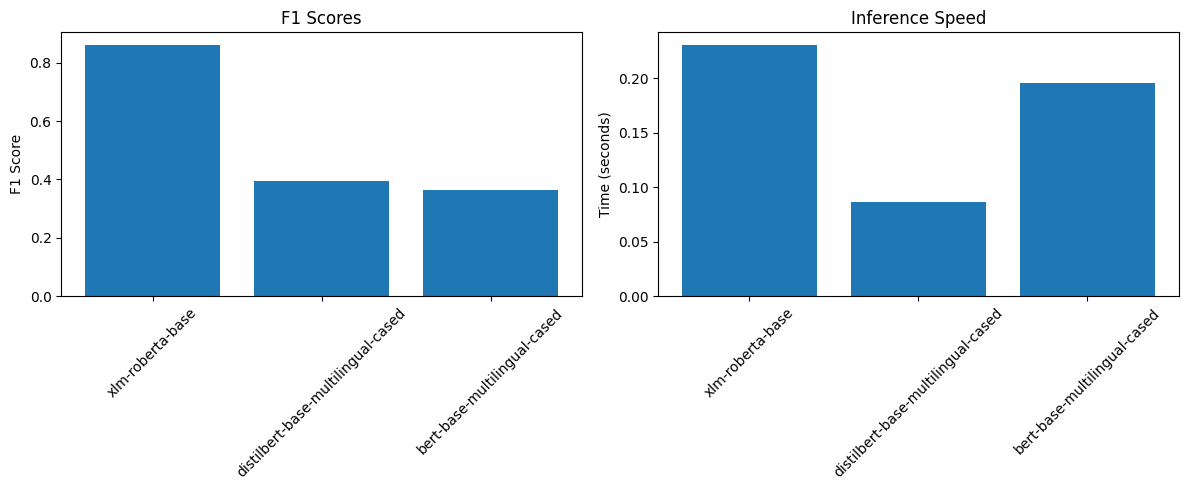

In [7]:
import matplotlib.pyplot as plt

if not results_df.empty:
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # F1 scores
    ax1.bar(results_df['model'], results_df['f1_score'])
    ax1.set_title('F1 Scores')
    ax1.set_ylabel('F1 Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Speed comparison
    ax2.bar(results_df['model'], results_df['avg_inference_time'])
    ax2.set_title('Inference Speed')
    ax2.set_ylabel('Time (seconds)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()